In [1]:
# Cell 1: Imports and setup
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import esm
from descriptastorus.descriptors import rdNormalizedDescriptors
import warnings
# import faiss
warnings.filterwarnings('ignore')

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Enable pandas progress bar
tqdm.pandas()

# Parameters
NUM_SAMPLES = None  # Will be set to match positive pairs
RANDOM_STATE = 5
# PCA_COMPONENTS = 50  # Number of PCA components for DR
# PLOT_COMPONENTS = [0, 1]  # Which PCs to use for 2D visualization
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

print("Setup complete!")

/home/nroethler/miniconda3/envs/gen_ca/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Setup complete!


In [2]:
# Cell 2: Load datasets and get target sample size
print("Loading datasets...")
df_complete = pd.read_csv("./datasets/cysdb_complete_with_sequences.csv").dropna(subset=['SMILES', 'Sequence'])
negatives = df_complete[df_complete['Activity'] == 0].reset_index(drop=True)[['Entry','SMILES', 'Sequence', 'Ratio','Activity']]
positives = df_complete[df_complete['Activity'] == 1].reset_index(drop=True)[['Entry','SMILES', 'Sequence', 'Ratio','Activity']]

# Set target sample size to match positives
NUM_SAMPLES = len(positives)
print(f"Target sample size: {NUM_SAMPLES:,}")
print(f"Available negatives: {len(negatives):,}")
print(f"Sampling ratio: {NUM_SAMPLES / len(negatives):.3f}")

Loading datasets...
Target sample size: 49,511
Available negatives: 12,201,748
Sampling ratio: 0.004


In [3]:
df_complete.head(10)

,Entry,cysteineid,resid,ligandable,backus_cravatt_ligandable,cao_backus_ligandable,kuljanin_gygi_ligandable,vinogradova_cravatt_ligandable,yan_backus_ligandable,yang_wang_ligandable,Compound,Ratio,Activity,SMILES,Sequence
0,P23396,P23396_C97,97,yes,yes,yes,NaN,yes,NaN,NaN,ACRYL_1,2.73,0,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MAVQISKKRKFVADGIFKAELNEFLTRELAEDGYSGVEVRVTPTRT...
1,P68366,P68366_C295,295,yes,yes,NaN,NaN,NaN,NaN,NaN,ACRYL_1,2.50,0,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MRECISVHVGQAGVQMGNACWELYCLEHGIQPDGQMPSDKTIGGGD...
2,P68366,P68366_C347,347,yes,yes,NaN,NaN,yes,NaN,NaN,ACRYL_1,3.10,0,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MRECISVHVGQAGVQMGNACWELYCLEHGIQPDGQMPSDKTIGGGD...
3,Q71U36,Q71U36_C347,347,yes,yes,yes,NaN,NaN,NaN,NaN,ACRYL_1,2.33,0,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MRECISIHVGQAGVQIGNACWELYCLEHGIQPDGQMPSDKTIGGGD...
4,Q71U36,Q71U36_C376,376,yes,yes,NaN,NaN,NaN,NaN,NaN,ACRYL_1,4.56,1,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MRECISIHVGQAGVQIGNACWELYCLEHGIQPDGQMPSDKTIGGGD...
5,Q7L1Q6,Q7L1Q6_C35,35,yes,yes,yes,NaN,NaN,NaN,NaN,ACRYL_1,1.57,0,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MNNQKQQKPTLSGQRFKTRKRDEKERFDPTQFQDCIIQGLTETGTD...
6,P04406,P04406_C152,152,yes,yes,yes,yes,NaN,yes,NaN,ACRYL_1,0.97,0,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MGKVKVGVNGFGRIGRLVTRAAFNSGKVDIVAINDPFIDLNYMVYM...
7,Q99873,Q99873_C109,109,yes,yes,NaN,yes,NaN,NaN,NaN,ACRYL_1,0.94,0,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MAAAEAANCIMENFVATLANGMSLQPPLEEVSCGQAESSEKPNAED...
8,Q15365,Q15365_C109,109,yes,yes,yes,yes,yes,yes,NaN,ACRYL_1,2.67,0,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MDAGVTESGLNVTLTIRLLMHGKEVGSIIGKKGESVKRIREESGAR...
9,Q13526,Q13526_C113,113,yes,yes,yes,yes,yes,NaN,yes,ACRYL_1,1.00,0,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MADEEKLPPGWEKRMSRSSGRVYYFNHITNASQWERPSGNSSSGGK...


In [3]:
df_complete[df_complete['Sequence'].isna()]['Entry'].size

0

In [4]:
positives.head(5)

,Entry,SMILES,Sequence,Ratio,Activity
0,Q71U36,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MRECISIHVGQAGVQIGNACWELYCLEHGIQPDGQMPSDKTIGGGD...,4.56,1
1,Q9Y266,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MGGEQEEERFDGMLLAMAQQHEGGVQELVNTFFSFLRRKTDFFIGG...,20.00,1
2,P10809,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MLRLPTVFRQMRPVSRVLAPHLTRAYAKDVKFGADARALMLQGVDL...,8.00,1
3,P13639,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MVNFTVDQIRAIMDKKANIRNMSVIAHVDHGKSTLTDSLVCKAGII...,10.17,1
4,Q15185,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MQPASAKWYDRRDYVFIEFCVEDSKDVNVNFEKSKLTFSCLGGSDN...,6.12,1


In [5]:
sampling_ratio = NUM_SAMPLES / len(negatives)

In [6]:
import torch
from esm.models.esmc import ESMC
from esm.sdk.api import (
    ESM3InferenceClient,
    ESMProtein,
    LogitsConfig,
    LogitsOutput,
    ProteinType,
)
EMBEDDING_CONFIG = LogitsConfig(
    sequence=True, return_embeddings=True, return_hidden_states=False
)
# Cell 3: ESM-C protein embeddings + RDKit normalized descriptors
print("Setting up ESM-C model...")
client = ESMC.from_pretrained("esmc_600m").to("cuda")
def embed_sequence(model: ESM3InferenceClient, sequence: str) -> torch.Tensor:
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.encode(protein)
    output = model.logits(protein_tensor, EMBEDDING_CONFIG)
    # output.embeddings: shape [1, seq_len, 1152]
    mean_embedding = output.embeddings.mean(dim=1).squeeze(0).detach().cpu().numpy()  # shape [1152]
    return mean_embedding

# Get unique proteins
proteins_unique = negatives['Sequence'].unique()
print(f"Unique proteins to embed: {len(proteins_unique):,}")

protein_embed_dict = {}

for sequence in tqdm(proteins_unique, total=len(proteins_unique), desc="Embedding proteins"):
    if sequence not in protein_embed_dict:
        try:
            embedding = embed_sequence(client, sequence)
            protein_embed_dict[sequence] = embedding
        except Exception as e:
            print(f"Error embedding {sequence}: {e}")


print("Generating protein embeddings...")



Setting up ESM-C model...


Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 22888.43it/s]


Unique proteins to embed: 9,391


Embedding proteins: 100%|██████████| 9391/9391 [03:07<00:00, 50.08it/s]

Generating protein embeddings...


In [7]:
len(protein_embed_dict)

9391

In [8]:
# Cell 4: RDKit molecular descriptors
print("Computing molecular descriptors...")
gen = rdNormalizedDescriptors.RDKit2DNormalized()

# Get unique molecules
unique_molecules = negatives['SMILES'].unique()
print(f"Unique molecules: {len(unique_molecules):,}")

# Storage for molecular features
molecule_features = {}

# Process molecules
for smiles in tqdm(unique_molecules, desc="RDKit descriptors"):
    try:
        desc = gen.process(smiles=smiles)
        if desc is not None and len(desc) > 1:
            molecule_features[smiles] = np.array(desc[1:], dtype=np.float32)
    except Exception as e:
        print(f"Error processing {smiles}: {e}")

print(f"Generated features for {len(molecule_features)} molecules")


Computing molecular descriptors...
Unique molecules: 352


RDKit descriptors: 100%|██████████| 352/352 [00:04<00:00, 84.87it/s]

Generated features for 352 molecules


In [24]:
# combine embeddings and molecular features
print("Combining protein embeddings and molecular features...")
negatives['Embedding'] = negatives['Sequence'].map(protein_embed_dict)
negatives['MoleculeFeatures'] = negatives['SMILES'].map(molecule_features)

# negatives.to_pickle("./datasets/negatives_with_embeddings.pkl")

Combining protein embeddings and molecular features...


In [34]:
# for idx, row in negatives.iterrows():
#     if row['Embedding'] is None or row['MoleculeFeatures'] is None:
#         print(f"Missing data for index {idx}: {row['Entry']}")
#     else:
#         row['concatenated_features'] = np.concatenate((row['Embedding'], row['MoleculeFeatures']))

negatives['concatenated_features'] = negatives.apply(
    lambda row: np.concatenate((row['Embedding'], row['MoleculeFeatures'])), axis=1
)

In [9]:
# more memory efficient storage
negatives['concatenated_features'] = negatives.apply(
    lambda row: np.concatenate((protein_embed_dict[row['Sequence']], molecule_features[row['SMILES']])), axis=1
)

In [6]:
negatives[negatives['concatenated_features'].isna()].size

0

In [7]:

# Prepare data for faiss (float32, contiguous)
features = np.stack(negatives['concatenated_features'].values).astype('float32')
features = np.ascontiguousarray(features)
features.tofile("./datasets/negatives_features.npy")

In [8]:
features.shape

(12201748, 1352)

In [18]:
features

memmap([[-1.1536329e-02,  2.3095624e-03,  1.2347347e-03, ...,
          4.7035982e-08,  1.6663340e-01,  8.0027163e-01],
        [-1.6161947e-02, -6.6832909e-03, -1.1377907e-02, ...,
          4.7035982e-08,  1.6663340e-01,  8.0027163e-01],
        [-1.6161947e-02, -6.6832909e-03, -1.1377907e-02, ...,
          4.7035982e-08,  1.6663340e-01,  8.0027163e-01],
        ...,
        [ 5.5164839e-03,  2.1060780e-03, -9.8280692e-03, ...,
          4.7035982e-08,  1.6663340e-01,  7.7521724e-01],
        [ 1.1217406e-02, -2.8066714e-03, -1.8393886e-05, ...,
          4.7035982e-08,  1.6663340e-01,  7.7521724e-01],
        [-6.7313593e-03,  3.6794054e-03, -1.0063098e-02, ...,
          4.7035982e-08,  1.6663340e-01,  7.7521724e-01]], dtype=float32)

In [17]:
features = np.memmap("./datasets/negatives_features.npy", dtype='float32', mode='r', shape=(12201748, 1352))

In [7]:
len(features)

12201748

In [12]:
import faiss 
faiss.get_num_gpus()

2

In [12]:
# Cell: Clustering with faiss-gpu
import faiss
import numpy as np
import gc
batch_size= 244034
n_points, d = features.shape
print(f"Number of points: {n_points}, Dimension: {d}")
# n_points = 12201748
print("Clustering with faiss-gpu...")
# Set number of clusters (e.g., same logic as before)
n_clusters = min(max(NUM_SAMPLES // 10, 10), 300)  # Between 10-300 clusters
print(f"Using {n_clusters} clusters")

# Initialize faiss KMeans (GPU)
ngpu= faiss.get_num_gpus()          
res = faiss.StandardGpuResources() 
kmeans = faiss.Kmeans(d=features.shape[1], k=n_clusters, gpu=True, niter=50, verbose=True, seed=5, max_points_per_centroid=2000000)

# Train KMeans
kmeans.train(features)

cpu_centroids = faiss.IndexFlatL2(d)
cpu_centroids.add(kmeans.centroids)

gpu_centroids = faiss.index_cpu_to_all_gpus(cpu_centroids)  # two-device copy


# Assign clusters
labels = np.empty(len(features), dtype=np.int32)
for start in range(0, len(features), batch_size):
    end = min(start + batch_size, len(features))
    batch = np.ascontiguousarray(features[start:end])
    _, I = gpu_centroids.search(batch, 1)
    labels[start:end] = I.ravel()

negatives['faiss_cluster'] = labels
print(f"Cluster assignment complete. Cluster counts:")
unique, counts = np.unique(labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Cluster {u}: {c} samples")

# Clean up GPU memory
del features, kmeans, res
gc.collect()

Number of points: 12201748, Dimension: 1352
Clustering with faiss-gpu...
Using 300 clusters
Clustering 12201748 points in 1352D to 300 clusters, redo 1 times, 50 iterations
  Preprocessing in 3.82 s
  Iteration 49 (139.55 s, search 103.80 s): objective=8.55145e+06 imbalance=1.523 nsplit=0       
Cluster assignment complete. Cluster counts:
  Cluster 0: 26653 samples
  Cluster 1: 40579 samples
  Cluster 2: 16344 samples
  Cluster 3: 42444 samples
  Cluster 4: 7713 samples
  Cluster 5: 40926 samples
  Cluster 6: 81296 samples
  Cluster 7: 80422 samples
  Cluster 8: 49507 samples
  Cluster 9: 41135 samples
  Cluster 10: 79729 samples
  Cluster 11: 85150 samples
  Cluster 12: 41059 samples
  Cluster 13: 83060 samples
  Cluster 14: 7711 samples
  Cluster 15: 44685 samples
  Cluster 16: 41052 samples
  Cluster 17: 39986 samples
  Cluster 18: 40822 samples
  Cluster 19: 25604 samples
  Cluster 20: 9915 samples
  Cluster 21: 25074 samples
  Cluster 22: 25955 samples
  Cluster 23: 30421 samples

817

In [13]:
negatives.head(5)

,Entry,SMILES,Sequence,Ratio,Activity,faiss_cluster
0,P23396,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MAVQISKKRKFVADGIFKAELNEFLTRELAEDGYSGVEVRVTPTRT...,2.73,0,23
1,P68366,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MRECISVHVGQAGVQMGNACWELYCLEHGIQPDGQMPSDKTIGGGD...,2.50,0,23
2,P68366,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MRECISVHVGQAGVQMGNACWELYCLEHGIQPDGQMPSDKTIGGGD...,3.10,0,23
3,Q71U36,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MRECISIHVGQAGVQIGNACWELYCLEHGIQPDGQMPSDKTIGGGD...,2.33,0,23
4,Q7L1Q6,C=CC(=O)N(c1ccccc1)c1ccc(Br)cc1,MNNQKQQKPTLSGQRFKTRKRDEKERFDPTQFQDCIIQGLTETGTD...,1.57,0,23


In [15]:
negatives.to_csv("./datasets/negatives_with_clusters.csv")

In [16]:
labels

array([ 23,  23,  23, ..., 120, 120, 120], dtype=int32)

In [21]:
# Cell 8: Stratified sampling from clusters
print("Performing stratified sampling...")

# Calculate samples per cluster (proportional to cluster size)
cluster_sizes = np.bincount(labels)
samples_per_cluster = np.round(
    (cluster_sizes / len(labels)) * NUM_SAMPLES
).astype(int)

print(f"Original cluster sizes: {cluster_sizes}")
print(f"Target samples per cluster: {samples_per_cluster}")

# Ensure we get exactly NUM_SAMPLES
diff = NUM_SAMPLES - samples_per_cluster.sum()
print(f"Sample difference to adjust: {diff}")

if diff > 0:
    # Add extra samples to largest clusters
    largest_clusters = np.argsort(cluster_sizes)[-diff:]
    samples_per_cluster[largest_clusters] += 1
elif diff < 0:
    # Remove samples from largest clusters
    largest_clusters = np.argsort(cluster_sizes)[diff:]
    samples_per_cluster[largest_clusters] -= 1

print(f"Adjusted samples per cluster: {samples_per_cluster}")
print(f"Total samples to select: {samples_per_cluster.sum()}")

# Sample from each cluster
sampled_indices = []
for cluster_id in tqdm(range(n_clusters), desc="Sampling clusters"):
    cluster_mask = labels == cluster_id
    cluster_indices = np.where(cluster_mask)[0]
    
    n_samples_cluster = min(samples_per_cluster[cluster_id], len(cluster_indices))
    if n_samples_cluster > 0:
        selected = np.random.choice(cluster_indices, n_samples_cluster, replace=False)
        sampled_indices.extend(selected)
        
    print(f"  Cluster {cluster_id}: {n_samples_cluster}/{len(cluster_indices)} samples selected")

sampled_indices = np.array(sampled_indices)
print(f"Total sampled indices: {len(sampled_indices)}")

# Create sampled dataset
sampled_negatives = negatives.iloc[sampled_indices].copy()

print(f"✅ Stratified sampling complete!")
print(f"Sampled dataset shape: {sampled_negatives.shape}")

# Memory cleanup
gc.collect()
# check_memory()

Performing stratified sampling...
Original cluster sizes: [ 26653  40579  16344  42444   7713  40926  81296  80422  49507  41135
  79729  85150  41059  83060   7711  44685  41052  39986  40822  25604
   9915  25074  25955  30421  24553 164637  15834  49153  40592   7693
  18919  40396  41835  81409  38656  41896 124751  25877  18294  79696
  40453  40590  16406  40354  85383  26966  15506   9380  11664  15474
  18396  16174  44319 122651  15599  22372  42721  43217  83349  41110
  41119  24975  34936  40128  41536   7783  40116  40122  98977  41570
  82117  15869  24940  41049  42014  17365  14849  24998  50461  15661
  39655  42644  25433  40124  48126  90508   8960  31545 209609  17953
  24671  15941  15581  25919  42564  86681  79482  25028  40467  41036
  24973   7576  42918   7905  41971  42546   7945  15252  80521  18436
  12041  40285  41129  16495  41564  83518  15572  26189   7853  50504
  42581  83662  41864  14905  41882 122005 128549  38912  81091  41563
  16199  83387  807

Sampling clusters:   0%|          | 0/300 [00:00<?, ?it/s]

Sampling clusters:  11%|█▏        | 34/300 [00:00<00:00, 333.85it/s]

  Cluster 0: 108/26653 samples selected
  Cluster 1: 165/40579 samples selected
  Cluster 2: 66/16344 samples selected
  Cluster 3: 172/42444 samples selected
  Cluster 4: 31/7713 samples selected
  Cluster 5: 166/40926 samples selected
  Cluster 6: 330/81296 samples selected
  Cluster 7: 326/80422 samples selected
  Cluster 8: 201/49507 samples selected
  Cluster 9: 167/41135 samples selected
  Cluster 10: 324/79729 samples selected
  Cluster 11: 346/85150 samples selected
  Cluster 12: 167/41059 samples selected
  Cluster 13: 337/83060 samples selected
  Cluster 14: 31/7711 samples selected
  Cluster 15: 181/44685 samples selected
  Cluster 16: 167/41052 samples selected
  Cluster 17: 162/39986 samples selected
  Cluster 18: 166/40822 samples selected
  Cluster 19: 104/25604 samples selected
  Cluster 20: 40/9915 samples selected
  Cluster 21: 102/25074 samples selected
  Cluster 22: 105/25955 samples selected
  Cluster 23: 123/30421 samples selected
  Cluster 24: 100/24553 samples s

Sampling clusters:  23%|██▎       | 68/300 [00:00<00:00, 335.20it/s]

  Cluster 60: 167/41119 samples selected
  Cluster 61: 101/24975 samples selected
  Cluster 62: 142/34936 samples selected
  Cluster 63: 163/40128 samples selected
  Cluster 64: 169/41536 samples selected
  Cluster 65: 32/7783 samples selected
  Cluster 66: 163/40116 samples selected
  Cluster 67: 163/40122 samples selected


Sampling clusters:  34%|███▍      | 102/300 [00:00<00:00, 334.14it/s]

  Cluster 68: 402/98977 samples selected
  Cluster 69: 169/41570 samples selected
  Cluster 70: 333/82117 samples selected
  Cluster 71: 64/15869 samples selected
  Cluster 72: 101/24940 samples selected
  Cluster 73: 167/41049 samples selected
  Cluster 74: 170/42014 samples selected
  Cluster 75: 70/17365 samples selected
  Cluster 76: 60/14849 samples selected
  Cluster 77: 101/24998 samples selected
  Cluster 78: 205/50461 samples selected
  Cluster 79: 64/15661 samples selected
  Cluster 80: 161/39655 samples selected
  Cluster 81: 173/42644 samples selected
  Cluster 82: 103/25433 samples selected
  Cluster 83: 163/40124 samples selected
  Cluster 84: 195/48126 samples selected
  Cluster 85: 367/90508 samples selected
  Cluster 86: 36/8960 samples selected
  Cluster 87: 128/31545 samples selected
  Cluster 88: 850/209609 samples selected
  Cluster 89: 73/17953 samples selected
  Cluster 90: 100/24671 samples selected
  Cluster 91: 65/15941 samples selected
  Cluster 92: 63/15581 

Sampling clusters:  45%|████▌     | 136/300 [00:00<00:00, 333.73it/s]

  Cluster 128: 329/81091 samples selected
  Cluster 129: 169/41563 samples selected
  Cluster 130: 66/16199 samples selected
  Cluster 131: 338/83387 samples selected
  Cluster 132: 328/80765 samples selected
  Cluster 133: 163/40076 samples selected
  Cluster 134: 176/43337 samples selected
  Cluster 135: 59/14648 samples selected


Sampling clusters:  57%|█████▋    | 170/300 [00:00<00:00, 335.91it/s]

  Cluster 136: 102/25234 samples selected
  Cluster 137: 332/81874 samples selected
  Cluster 138: 165/40583 samples selected
  Cluster 139: 62/15217 samples selected
  Cluster 140: 173/42579 samples selected
  Cluster 141: 169/41568 samples selected
  Cluster 142: 67/16607 samples selected
  Cluster 143: 35/8679 samples selected
  Cluster 144: 164/40331 samples selected
  Cluster 145: 63/15611 samples selected
  Cluster 146: 64/15875 samples selected
  Cluster 147: 165/40597 samples selected
  Cluster 148: 77/19078 samples selected
  Cluster 149: 75/18483 samples selected
  Cluster 150: 506/124930 samples selected
  Cluster 151: 74/18190 samples selected
  Cluster 152: 64/15661 samples selected
  Cluster 153: 201/49483 samples selected
  Cluster 154: 39/9690 samples selected
  Cluster 155: 77/19055 samples selected
  Cluster 156: 163/40231 samples selected
  Cluster 157: 510/125977 samples selected
  Cluster 158: 63/15533 samples selected
  Cluster 159: 166/40829 samples selected
  Cl

Sampling clusters:  68%|██████▊   | 204/300 [00:00<00:00, 335.58it/s]

  Cluster 196: 99/24502 samples selected
  Cluster 197: 66/16275 samples selected
  Cluster 198: 335/82642 samples selected
  Cluster 199: 164/40304 samples selected
  Cluster 200: 101/24867 samples selected
  Cluster 201: 68/16674 samples selected
  Cluster 202: 169/41595 samples selected
  Cluster 203: 169/41571 samples selected


Sampling clusters:  79%|███████▉  | 238/300 [00:00<00:00, 332.71it/s]

  Cluster 204: 32/7780 samples selected
  Cluster 205: 173/42569 samples selected
  Cluster 206: 157/38654 samples selected
  Cluster 207: 63/15567 samples selected
  Cluster 208: 173/42562 samples selected
  Cluster 209: 129/31819 samples selected
  Cluster 210: 8/1878 samples selected
  Cluster 211: 130/32069 samples selected
  Cluster 212: 174/42925 samples selected
  Cluster 213: 334/82371 samples selected
  Cluster 214: 225/55414 samples selected
  Cluster 215: 97/23807 samples selected
  Cluster 216: 379/93495 samples selected
  Cluster 217: 329/81183 samples selected
  Cluster 218: 170/41860 samples selected
  Cluster 219: 157/38642 samples selected
  Cluster 220: 137/33762 samples selected
  Cluster 221: 166/40830 samples selected
  Cluster 222: 512/126441 samples selected
  Cluster 223: 165/40594 samples selected
  Cluster 224: 176/43341 samples selected
  Cluster 225: 339/83499 samples selected
  Cluster 226: 329/81194 samples selected
  Cluster 227: 61/15028 samples selected

Sampling clusters: 100%|██████████| 300/300 [00:00<00:00, 334.78it/s]


  Cluster 272: 64/15815 samples selected
  Cluster 273: 101/24786 samples selected
  Cluster 274: 65/16003 samples selected
  Cluster 275: 173/42706 samples selected
  Cluster 276: 100/24743 samples selected
  Cluster 277: 167/41047 samples selected
  Cluster 278: 170/41875 samples selected
  Cluster 279: 105/25873 samples selected
  Cluster 280: 165/40630 samples selected
  Cluster 281: 99/24349 samples selected
  Cluster 282: 337/83029 samples selected
  Cluster 283: 167/41075 samples selected
  Cluster 284: 157/38657 samples selected
  Cluster 285: 173/42561 samples selected
  Cluster 286: 100/24579 samples selected
  Cluster 287: 548/135275 samples selected
  Cluster 288: 163/40122 samples selected
  Cluster 289: 172/42470 samples selected
  Cluster 290: 164/40429 samples selected
  Cluster 291: 75/18393 samples selected
  Cluster 292: 67/16526 samples selected
  Cluster 293: 166/40940 samples selected
  Cluster 294: 33/8079 samples selected
  Cluster 295: 337/82929 samples selecte

487

In [23]:
sampled_negatives.to_csv("./datasets/sample_negatives_stratified_faiss.csv", index=False)

In [ ]:
# Cell 9: Simplest coverage calculation (no distance calculations)
print("Calculating coverage score with simplest method...")

# Use 2D PCA coordinates for coverage calculation
all_points = pca_2d
sampled_points = pca_2d[sampled_indices]

print(f"All points shape: {all_points.shape}")
print(f"Sampled points shape: {sampled_points.shape}")

def calculate_simple_coverage(all_points, sampled_points):
    """Super simple coverage calculation - no distance matrices"""
    
    print("Computing basic coverage metrics...")
    
    # 1. Grid-based coverage only (very safe)
    print("  Computing grid-based coverage...")
    x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
    y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
    
    # Small grid to be extra safe
    grid_size = 30
    x_bins = np.linspace(x_min, x_max, grid_size)
    y_bins = np.linspace(y_min, y_max, grid_size)
    
    # Count occupied cells
    all_hist, _, _ = np.histogram2d(all_points[:, 0], all_points[:, 1], 
                                   bins=[x_bins, y_bins])
    sampled_hist, _, _ = np.histogram2d(sampled_points[:, 0], sampled_points[:, 1], 
                                       bins=[x_bins, y_bins])
    
    non_empty_cells = all_hist > 0
    covered_cells = (sampled_hist > 0) & non_empty_cells
    grid_coverage = covered_cells.sum() / non_empty_cells.sum()
    
    # 2. Density coverage (trivial calculation)
    density_coverage = len(sampled_points) / len(all_points)
    
    # 3. Spread coverage (how well spread out are samples)
    sampled_x_range = sampled_points[:, 0].max() - sampled_points[:, 0].min()
    sampled_y_range = sampled_points[:, 1].max() - sampled_points[:, 1].min()
    
    total_x_range = x_max - x_min
    total_y_range = y_max - y_min
    
    x_spread_coverage = sampled_x_range / total_x_range
    y_spread_coverage = sampled_y_range / total_y_range
    spread_coverage = (x_spread_coverage + y_spread_coverage) / 2
    
    # 4. Quartile coverage (are samples in all 4 quadrants?)
    x_mid = (x_min + x_max) / 2
    y_mid = (y_min + y_max) / 2
    
    q1_samples = np.sum((sampled_points[:, 0] <= x_mid) & (sampled_points[:, 1] <= y_mid))
    q2_samples = np.sum((sampled_points[:, 0] > x_mid) & (sampled_points[:, 1] <= y_mid))
    q3_samples = np.sum((sampled_points[:, 0] <= x_mid) & (sampled_points[:, 1] > y_mid))
    q4_samples = np.sum((sampled_points[:, 0] > x_mid) & (sampled_points[:, 1] > y_mid))
    
    quadrants_covered = sum([q > 0 for q in [q1_samples, q2_samples, q3_samples, q4_samples]])
    quadrant_coverage = quadrants_covered / 4.0
    
    # Combined score (no distance calculations needed)
    combined_score = (grid_coverage + spread_coverage + quadrant_coverage) / 3
    
    return {
        'grid_coverage': grid_coverage,
        'density_coverage': density_coverage,
        'spread_coverage': spread_coverage,
        'quadrant_coverage': quadrant_coverage,
        'combined_score': combined_score,
        'quadrant_counts': [q1_samples, q2_samples, q3_samples, q4_samples],
        'x_spread_ratio': x_spread_coverage,
        'y_spread_ratio': y_spread_coverage
    }

# Calculate coverage with simple method (no crashes possible)
print("Starting simple coverage calculation...")
check_memory()

coverage_metrics = calculate_simple_coverage(all_points, sampled_points)

print("\n" + "="*50)
print("SIMPLE COVERAGE METRICS")
print("="*50)
print(f"Grid coverage: {coverage_metrics['grid_coverage']:.3f}")
print(f"Spread coverage: {coverage_metrics['spread_coverage']:.3f}")
print(f"Quadrant coverage: {coverage_metrics['quadrant_coverage']:.3f}")
print(f"Density coverage: {coverage_metrics['density_coverage']:.3f}")
print(f"Combined score: {coverage_metrics['combined_score']:.3f}")
print()
print("Coverage Details:")
print(f"  X-axis spread: {coverage_metrics['x_spread_ratio']:.3f}")
print(f"  Y-axis spread: {coverage_metrics['y_spread_ratio']:.3f}")
print(f"  Quadrant samples: {coverage_metrics['quadrant_counts']}")

# Memory cleanup
gc.collect()
# check_memory()

print("✅ Simple coverage calculation complete (no crashes possible)!")

Calculating coverage score with simplest method...
All points shape: (12201748, 2)
Sampled points shape: (49511, 2)
Starting simple coverage calculation...
Memory: 63.2% used, Process: 74.3 GB, Available: 44.8 GB
Computing basic coverage metrics...
  Computing grid-based coverage...



SIMPLE COVERAGE METRICS
Grid coverage: 0.909
Spread coverage: 0.968
Quadrant coverage: 1.000
Density coverage: 0.004
Combined score: 0.959

Coverage Details:
  X-axis spread: 0.968
  Y-axis spread: 0.969
  Quadrant samples: [np.int64(5672), np.int64(35874), np.int64(1003), np.int64(6962)]
Memory: 63.2% used, Process: 74.3 GB, Available: 44.8 GB
✅ Simple coverage calculation complete (no crashes possible)!


Creating visualization...


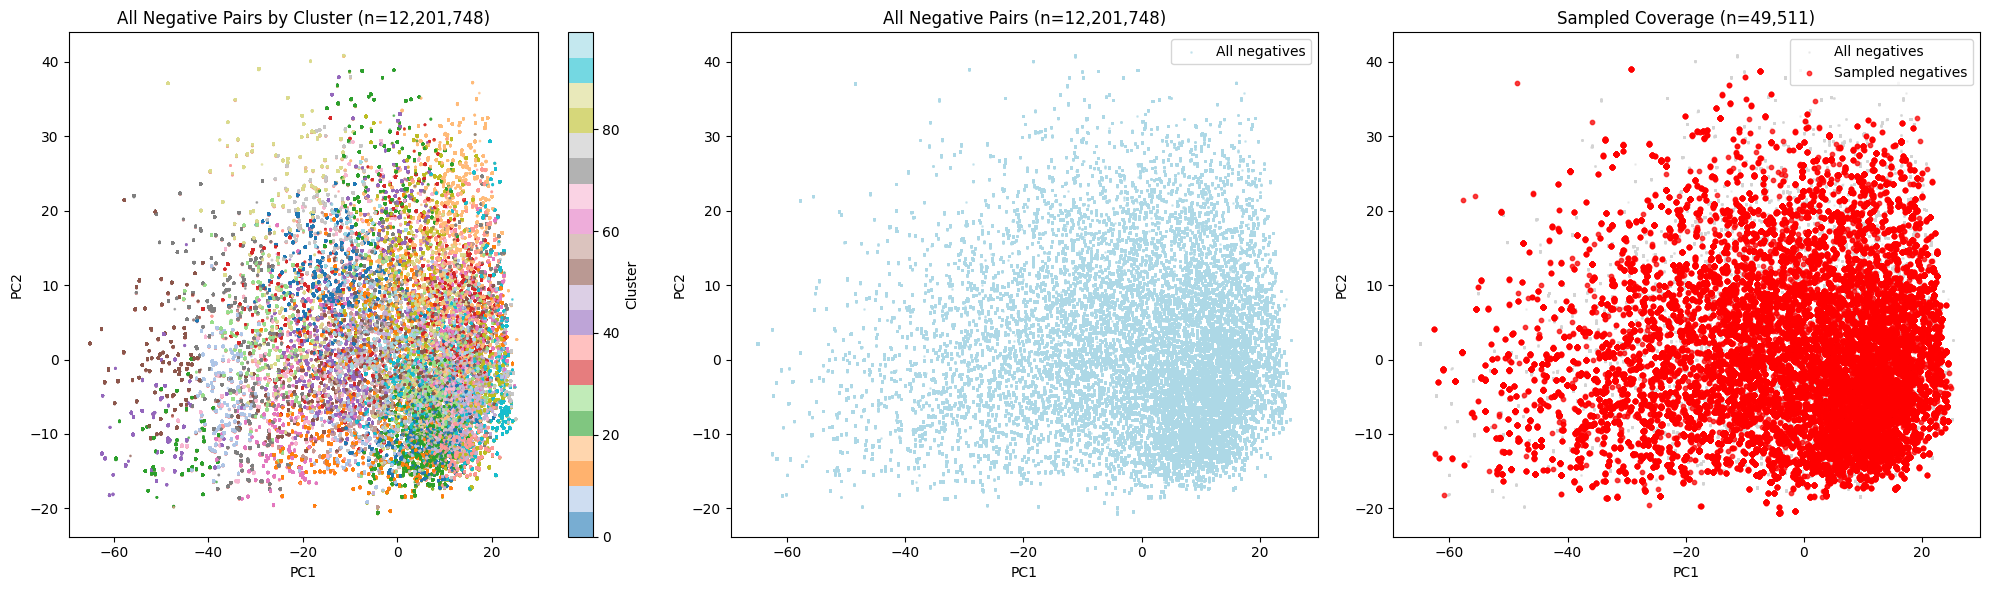

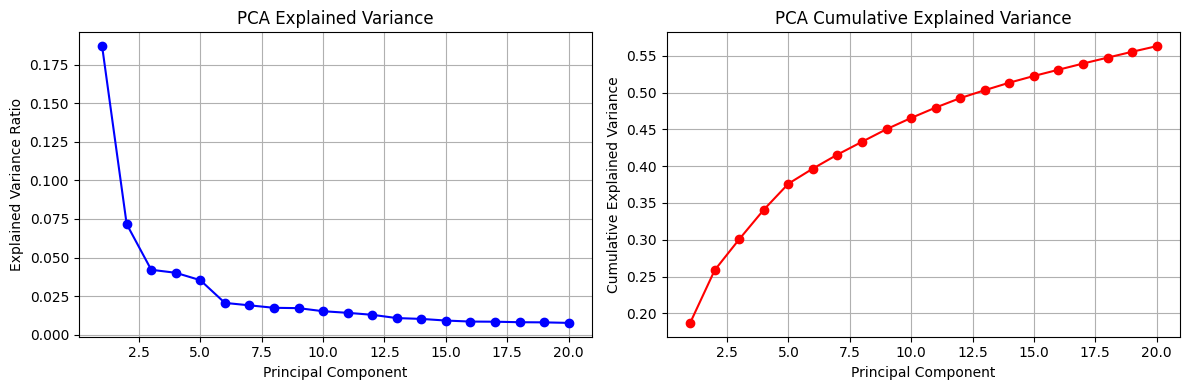

In [10]:
# Cell 10: Create visualization
print("Creating visualization...")

plt.figure(figsize=(20, 6))

# Plot 1: All points colored by cluster
plt.subplot(1, 3, 1)
scatter = plt.scatter(pca_2d[:, 0], pca_2d[:, 1], 
                     c=cluster_labels, alpha=0.6, s=1, cmap='tab20')
plt.title(f'All Negative Pairs by Cluster (n={len(pca_2d):,})')
plt.xlabel(f'PC{PLOT_COMPONENTS[0]+1}')
plt.ylabel(f'PC{PLOT_COMPONENTS[1]+1}')
plt.colorbar(scatter, label='Cluster')

# Plot 2: All points
plt.subplot(1, 3, 2)
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], 
           c='lightblue', alpha=0.5, s=1, label='All negatives')
plt.title(f'All Negative Pairs (n={len(pca_2d):,})')
plt.xlabel(f'PC{PLOT_COMPONENTS[0]+1}')
plt.ylabel(f'PC{PLOT_COMPONENTS[1]+1}')
plt.legend()

# Plot 3: Sampled points over all points
plt.subplot(1, 3, 3)
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], 
           c='lightgray', alpha=0.3, s=1, label='All negatives')
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], 
           c='red', alpha=0.7, s=10, label='Sampled negatives')
plt.title(f'Sampled Coverage (n={len(sampled_points):,})')
plt.xlabel(f'PC{PLOT_COMPONENTS[0]+1}')
plt.ylabel(f'PC{PLOT_COMPONENTS[1]+1}')
plt.legend()

plt.tight_layout()
plt.savefig('negative_sampling_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional PCA analysis plot
plt.figure(figsize=(12, 4))

# Plot explained variance
plt.subplot(1, 2, 1)
plt.plot(range(1, min(21, len(pca.explained_variance_ratio_)+1)), 
         pca.explained_variance_ratio_[:20], 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.grid(True)

# Plot cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, min(21, len(pca.explained_variance_ratio_)+1)), 
         pca.explained_variance_ratio_[:20].cumsum(), 'ro-')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.grid(True)

plt.tight_layout()
plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [13]:
# Cell 10: Create visualization (updated)
print("Creating visualization...")

plt.figure(figsize=(20, 6))

# Plot 1: All points colored by cluster
plt.subplot(1, 3, 1)
scatter = plt.scatter(pca_2d[:, 0], pca_2d[:, 1],
                     c=cluster_labels, alpha=0.8, s=10, cmap='tab20')
plt.xlabel(f'PC{PLOT_COMPONENTS[0]+1}')
plt.ylabel(f'PC{PLOT_COMPONENTS[1]+1}')
plt.colorbar(scatter, label='Cluster')

# Plot 2: All points
plt.subplot(1, 3, 2)
plt.scatter(pca_2d[:, 0], pca_2d[:, 1],
           c='blue', alpha=0.5, s=10, label=f'All negatives (n={len(pca_2d):,})')
plt.xlabel(f'PC{PLOT_COMPONENTS[0]+1}')
plt.ylabel(f'PC{PLOT_COMPONENTS[1]+1}')
plt.legend()

# Plot 3: Sampled points over all points with different markers for visibility
plt.subplot(1, 3, 3)
# Plot all points first (background) - same size as sampled
plt.scatter(pca_2d[:, 0], pca_2d[:, 1],
           c='tab:blue', alpha=0.8, s=10, marker='*', 
           label=f'All negatives (n={len(pca_2d):,})')
# Overlay sampled points on top with different marker but SAME SIZE
plt.scatter(sampled_points[:, 0], sampled_points[:, 1],
           c='orange', alpha=0.8, s=10, marker='*', 
           label=f'Sampled negatives (n={len(sampled_points):,})')
plt.xlabel(f'PC{PLOT_COMPONENTS[0]+1}')
plt.ylabel(f'PC{PLOT_COMPONENTS[1]+1}')
plt.legend()

plt.tight_layout()
plt.savefig('negative_sampling_visualization_new.png', dpi=300, bbox_inches='tight')
plt.show()

Creating visualization...


KeyboardInterrupt: 

In [20]:
# Cell 11: Save results (CSV only)
print("Saving results...")

# Save sampled negatives
sampled_negatives.to_csv('sampled_negatives.csv', index=False)

# Calculate combined feature dimension from components
protein_dim = len(list(protein_embeddings.values())[0])
molecule_dim = len(list(molecule_features.values())[0])
combined_dim = protein_dim + molecule_dim

print("\nSummary:")
print(f"Original negatives: {len(negatives):,}")
print(f"Valid negatives: {len(valid_negatives):,}")
print(f"Sampled negatives: {len(sampled_negatives):,}")
print(f"Target (positives): {NUM_SAMPLES:,}")
print(f"Coverage score: {coverage_metrics['combined_score']:.3f}")

print(f"\nFeature dimensions:")
print(f"  Protein embeddings: {protein_dim}")
print(f"  Molecule features: {molecule_dim}")
print(f"  Combined features: {combined_dim}")
print(f"  PCA reduced: {pca_features.shape[1]}")

print(f"\nCoverage metrics:")
for key, value in coverage_metrics.items():
    if isinstance(value, (list, tuple)):
        print(f"  {key}: {[float(x) for x in value]}")
    else:
        print(f"  {key}: {float(value):.4f}")

print(f"\nPCA info:")
print(f"  Components used: {PCA_COMPONENTS}")
print(f"  Total explained variance: {float(pca.explained_variance_ratio_.sum()):.4f}")
print(f"  Shape after PCA: {pca_features.shape}")

print(f"\nClustering info:")
print(f"  Method: MiniBatch K-means")
print(f"  Number of clusters: {n_clusters}")
print(f"  Random state: {RANDOM_STATE}")

print("\nFiles created:")
print("- sampled_negatives.csv")
print("- negative_sampling_visualization.png")
print("- pca_analysis.png")

# Final memory cleanup and check
gc.collect()
check_memory()

print("\n✅ Pipeline complete!")

Saving results...

Summary:
Original negatives: 12,201,748
Valid negatives: 12,201,748
Sampled negatives: 49,511
Target (positives): 49,511
Coverage score: 0.959

Feature dimensions:
  Protein embeddings: 1280
  Molecule features: 200
  Combined features: 1480
  PCA reduced: 50

Coverage metrics:
  grid_coverage: 0.9089
  density_coverage: 0.0041
  spread_coverage: 0.9683
  quadrant_coverage: 1.0000
  combined_score: 0.9591
  quadrant_counts: [5672.0, 35874.0, 1003.0, 6962.0]
  x_spread_ratio: 0.9678
  y_spread_ratio: 0.9688

PCA info:
  Components used: 50
  Total explained variance: 0.6993
  Shape after PCA: (12201748, 50)

Clustering info:
  Method: MiniBatch K-means
  Number of clusters: 100
  Random state: 42

Files created:
- sampled_negatives.csv
- negative_sampling_visualization.png
- pca_analysis.png
Memory: 64.5% used, Process: 75.4 GB, Available: 43.2 GB

✅ Pipeline complete!
